In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier, XGBRegressor

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import roc_auc_score, make_scorer, f1_score

import warnings
warnings.filterwarnings('ignore')

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
# Training set is too large for me to run locally
train = pd.read_csv('train.csv')
# train = train.sample(8000)
# train = train.reset_index()
del train['id']
# del train['index']
test = pd.read_csv('test.csv')

# For readability
train['comment_text'] = train['comment_text'].str.replace('\n', ' ')
test['comment_text'] = test['comment_text'].str.replace('\n', ' ')

In [4]:
train['comment_text'] = train['comment_text'].fillna('_BLANK_')
test['comment_text'] = test['comment_text'].fillna('_BLANK_')

In [5]:
from string import punctuation

def check_for_all_caps(comment):
    comment = comment.translate(str.maketrans("", "", punctuation))
    if comment.isupper():
        return 1
    else:
        return 0

def check_for_some_caps(comment):
    if comment[:20].isupper():
        return 1
    else:
        return 0

train['comment_length'] = train['comment_text'].apply(len)
train['comment_word_count'] = train['comment_text'].apply(lambda x: len(x.split()))
train['comment_exclamation'] = train['comment_text'].apply(lambda x: x.count('!'))
train['comment_exclamation_binary'] = np.where(train['comment_exclamation'] > 0, 1, 0)
train['comment_entirely_caps'] = train['comment_text'].apply(check_for_all_caps)
train['comment_contains_caps'] = train['comment_text'].apply(check_for_some_caps)

test['comment_length'] = test['comment_text'].apply(len)
test['comment_word_count'] = test['comment_text'].apply(lambda x: len(x.split()))
test['comment_exclamation'] = test['comment_text'].apply(lambda x: x.count('!'))
test['comment_exclamation_binary'] = np.where(test['comment_exclamation'] > 0, 1, 0)
test['comment_entirely_caps'] = test['comment_text'].apply(check_for_all_caps)
test['comment_contains_caps'] = test['comment_text'].apply(check_for_some_caps)

In [6]:
#PROCESS RAW TEXT
from keras.preprocessing.text import Tokenizer

print("Text to seq process...")
raw_text = np.hstack([train.comment_text.str.lower(), test.comment_text.str.lower()])

print("Fitting tokenizer...")
tokenizer = Tokenizer(num_words=50000)
tokenizer.fit_on_texts(raw_text)

print("Transforming text to seq...")
train["seq_comment"] = tokenizer.texts_to_sequences(train.comment_text.str.lower())
test["seq_comment"] = tokenizer.texts_to_sequences(test.comment_text.str.lower())

train.head(3)

Using TensorFlow backend.


Text to seq process...
Fitting tokenizer...
Transforming text to seq...


,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,comment_length,comment_word_count,comment_exclamation,comment_exclamation_binary,comment_entirely_caps,comment_contains_caps,seq_comment
0,"Nonsense? kiss off, geek. what I said is true...",1,0,0,0,0,0,83,14,0,0,0,0,"[881, 2426, 307, 9418, 52, 9, 216, 8, 406, 331..."
1,""" Please do not vandalize pages, as you did ...",0,0,0,0,0,0,142,29,0,0,0,0,"[33, 36, 18, 443, 103, 20, 6, 90, 28, 16, 51, ..."
2,""" """"Points of interest"""" I removed the """"p...",0,0,0,0,0,0,411,69,0,0,0,0,"[740, 3, 517, 9, 179, 1, 740, 3, 517, 148, 6, ..."


In [7]:
# CREATE VALIDATION DATA
dtrain, dval = train_test_split(train, random_state=100, test_size=0.10)

print(dtrain.shape)
print(dval.shape)

(86265, 14)
(9586, 14)


In [8]:
y_train = dtrain[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].copy()
del dtrain['toxic']
del dtrain['severe_toxic']
del dtrain['obscene']
del dtrain['threat']
del dtrain['insult']
del dtrain['identity_hate']

y_val = dval[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].copy()
del dval['toxic']
del dval['severe_toxic']
del dval['obscene']
del dval['threat']
del dval['insult']
del dval['identity_hate']

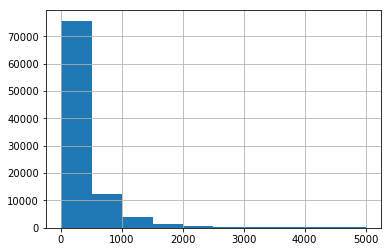

In [9]:
train.comment_length.hist()

In [10]:
MAX_COMMENT_LEN = 1000

MAX_TOKEN = len(tokenizer.word_index) + 1
MAX_TOKEN

378178

In [11]:
# KERAS DATA DEFINITION
from keras.preprocessing.sequence import pad_sequences

def get_keras_data(dataset):
    X = {
        'comment_text': pad_sequences(dataset.seq_comment, maxlen=1000),
        'comment_length': np.array(dataset.comment_length),
        'comment_word_count': np.array(dataset.comment_word_count),
        'comment_exclamation': np.array(dataset.comment_exclamation),
        'comment_exclamation_binary': np.array(dataset.comment_exclamation_binary),
        'comment_entirely_caps': np.array(dataset.comment_entirely_caps),
        'comment_contains_caps': np.array(dataset.comment_contains_caps),
    }
    return X

# X
X_train = get_keras_data(dtrain)
X_val = get_keras_data(dval)

X_test = get_keras_data(test)

In [13]:
#KERAS MODEL DEFINITION
from keras.layers import (Input, Dropout, Dense, BatchNormalization, Activation,
                          concatenate, LSTM, Embedding, Flatten, BatchNormalization)
from keras.models import Model
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras import backend as K

def get_model_rnn():
    #params
    dropout_rate = 0.1
    
    #Inputs
    comment_text               = Input(shape=[MAX_COMMENT_LEN], name="comment_text")
    comment_length             = Input(shape=[1], name="comment_length")
    comment_word_count         = Input(shape=[1], name="comment_word_count")
    comment_exclamation        = Input(shape=[1], name="comment_exclamation")
    comment_exclamation_binary = Input(shape=[1], name="comment_exclamation_binary")
    comment_entirely_caps      = Input(shape=[1], name="comment_entirely_caps")
    comment_contains_caps      = Input(shape=[1], name="comment_contains_caps")
    
    #Embedding layers
    emb_comment_text               = Embedding(MAX_TOKEN, 100)(comment_text)
    emb_comment_length             = Embedding(1, 1)(comment_length)
    emb_comment_word_count         = Embedding(1, 1)(comment_word_count)
    emb_comment_exclamation        = Embedding(1, 1)(comment_exclamation)
    emb_comment_exclamation_binary = Embedding(1, 1)(comment_exclamation_binary)
    emb_comment_entirely_caps      = Embedding(1, 1)(comment_entirely_caps)
    emb_comment_contains_caps      = Embedding(1, 1)(comment_contains_caps)
    
    #rnn layer
    rnn_layer1 = LSTM(32)(emb_comment_text)
    
    #main layer
    main_layer = concatenate([
        Flatten() (emb_comment_text),
        Flatten() (emb_comment_length),
        Flatten() (emb_comment_word_count),
        Flatten() (emb_comment_exclamation),
        Flatten() (emb_comment_exclamation_binary),
        Flatten() (emb_comment_entirely_caps),
        Flatten() (emb_comment_contains_caps),
        rnn_layer1,
    ])
    main_layer = Dropout(dropout_rate) (Dense(128) (main_layer))
    main_layer = Dropout(dropout_rate) (Dense(64) (main_layer))
    
    #output
    output = Dense(6, activation="softmax") (main_layer)
    
    #model
    model = Model([comment_text,
                   comment_length,
                   comment_word_count,
                   comment_exclamation,
                   comment_exclamation_binary,
                   comment_entirely_caps,
                   comment_contains_caps],
                  output)
    model.compile(loss="categorical_crossentropy", optimizer="adam")
    
    return model

    
model = get_model_rnn()

#FITTING THE MODEL
BATCH_SIZE = 64
epochs = 1

es = EarlyStopping(patience=1)

model = get_model_rnn()
model.fit(X_train, y_train, epochs=epochs, batch_size=BATCH_SIZE,
          validation_data=(X_val, y_val), verbose=1, callbacks=[es])

Train on 86265 samples, validate on 9586 samples
Epoch 1/1
86265/86265 [==============================] - 11020s 128ms/step - loss: 0.6755 - val_loss: 0.3112